## HS-Palmer omics traits analysis：

This notebook explains the process for obtaining and pre-processing omics mean genotype data of HS Rats used for downstream association studies.

In [1]:
pwd()

"/home/zyu20/git/BulkLMM_Analyses/HS-Palmer"

## Preworks:

In [2]:
using CSV, DelimitedFiles, DataFrames, Missings, XLSX
using LinearAlgebra, Statistics, Optim, StatsBase
using Random, Distributions
using BenchmarkTools
using Plots

### Load omics traits and convert to array:

In [3]:
@time omics_pheno_df = CSV.read("/home/zyu20/shareddata/HSNIH-Palmer/HSNIH-Rat-PL-RSeq-0818_nomissing.csv", DataFrame);

 12.943680 seconds (7.46 M allocations: 427.961 MiB, 0.88% gc time, 90.03% compilation time)


After removing missings the traits data have 32624 traits on 80 samples:

In [4]:
size(omics_pheno_df)

(80, 32624)

In [5]:
omics_pheno_df[1:10, 1:10]

Row,id,ENSRNOG00000000001,ENSRNOG00000000007,ENSRNOG00000000008,ENSRNOG00000000009,ENSRNOG00000000010,ENSRNOG00000000012,ENSRNOG00000000017,ENSRNOG00000000021,ENSRNOG00000000024
,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,00077E67B5,3.6379,11.9384,1.5656,0.142,8.1366,4.2163,2.9092,7.6822,9.5078
2,00077E76FE,3.7742,11.9253,1.5245,-0.068,8.2848,4.663,2.8339,7.8128,9.5016
3,00077E8336,3.554,12.2001,1.3987,-0.0679,8.1853,4.5741,2.5846,7.705,9.4759
4,00077EA7E6,3.3301,11.9553,1.6367,-0.0218,8.066,4.4902,2.5845,7.6575,9.3513
5,00078A0224,3.5547,12.0272,1.5649,-0.0217,8.3169,4.5341,2.6773,7.8402,9.3225
6,00078A02CB,3.8215,12.0395,1.3515,-0.0679,8.3208,4.5923,2.6765,7.6363,9.4791
7,00078A0A43,3.6407,12.0575,1.4871,-0.0678,8.2847,4.6763,2.7223,7.7997,9.4048
8,00078A18A7,3.6343,12.0777,1.4854,-0.0679,8.0468,4.7543,2.7599,7.8119,9.3522
9,00078A193E,3.6807,12.1188,1.5244,-0.068,8.1551,4.8433,2.7173,7.9472,9.2675


Column names are the names of the omics:

In [6]:
names(omics_pheno_df)[1:6]

6-element Vector{String}:
 "id"
 "ENSRNOG00000000001"
 "ENSRNOG00000000007"
 "ENSRNOG00000000008"
 "ENSRNOG00000000009"
 "ENSRNOG00000000010"

Row names are the ID's of the samples. Obtaining sample id's for the samples of the omics traits...

In [7]:
sample_ids = omics_pheno_df[:, 1];

Get the numeric array of the traits data...

#### “0.0” observations for all samples at some traits: 

In [8]:
omics_pheno = omics_pheno_df[:, 2:end] |> Matrix{Float64};
omics_pheno[:, :]

80×32623 Matrix{Float64}:
 3.6379  11.9384  1.5656   0.142   …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.7742  11.9253  1.5245  -0.068      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.554   12.2001  1.3987  -0.0679     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.3301  11.9553  1.6367  -0.0218     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.5547  12.0272  1.5649  -0.0217     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.8215  12.0395  1.3515  -0.0679  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.6407  12.0575  1.4871  -0.0678     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.6343  12.0777  1.4854  -0.0679     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.6807  12.1188  1.5244  -0.068      0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.8224  12.0631  1.3515  -0.0679     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.6883  12.1836  1.8251  -0.0679  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.4971  12.1465  1.3516  -0.0679     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 3.6853  11.9484  1.4855  -0.0218     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                                 ⋱  

Notice that there are some traits with all 0.0 values. Remove missings or columns of all 0's...

In [9]:
no_value_traits = vec(sum(abs.(omics_pheno), dims = 1) .== 0.0);

In [10]:
omics_pheno_processed = omics_pheno[:, map(x -> x .== 0.0, no_value_traits)];

In [11]:
size(omics_pheno_processed)

(80, 18416)

The processed traits data after removing potentially missing values have 18416 traits.

### Load omics genotype data and convert to array:

The genotyped data has been through the pre-processing of filtering out observations for samples that are not phenotyped, and removing missing values...the processes are detailed in the notebook `process_omics_geno.ipynb`.

In [12]:
@time omics_geno_df = CSV.read("/home/zyu20/shareddata/HSNIH-Palmer/HSNIH-Palmer_true_omics_geno_nomissing.csv", DataFrame);

  2.405879 seconds (7.15 M allocations: 444.518 MiB, 97.06% compilation time)


In [13]:
omics_geno_df

Row,Chr,Locus,cM,Mb,00077E67B5,00077E76FE,00077E8336,00077EA7E6,00078A002C,00078A0041,00078A0058,00078A0085,00078A00AC,00078A00BF,00078A01A6,00078A01C0,00078A01D8,00078A01DB,00078A01FE,00078A02CB,00078A02DF,00078A07A2,00078A09B1,00078A021A,00078A022D,00078A087B,00078A096C,00078A0127,00078A0138,00078A0139,00078A0166,00078A0215,00078A0224,00078A0246,00078A0255,00078A0A43,00078A0AEA,00078A1A2B,00078A1A16,00078A1B05,00078A1F34,00078A16D3,00078A16DF,00078A17F7,00078A18A7,00078A18CF,00078A18F7,00078A19A7,00078A19B5,00078A19C0,00078A19D6,00078A22DF,00078A22EB,00078A179C,00078A181B,00078A186C,00078A192C,00078A193E,00078A194B,00078A261F,00078A1707,00078A1731,00078A1732,00078A1772,00078A1807,00078A1816,00078A1837,00078A1863,00078A1875,00078A1937,00078A1942,00078A1979,00078A2315,00078A2463,00078A2496,00078A2595,00078A2667,000789FF6E,000789FF7D,000789FF94,000789FFD3,000789FFF0,000789FFF8,000789FFF9
,Int64,String15,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,chr1:55365,0.055365,0.055365,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
2,1,chr1:666374,0.666374,0.666374,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,1,chr1:666382,0.666382,0.666382,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,1,chr1:666394,0.666394,0.666394,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
5,1,chr1:669529,0.669529,0.669529,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
6,1,chr1:669562,0.669562,0.669562,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0
7,1,chr1:671466,0.671466,0.671466,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0

In [14]:
@time omics_geno = omics_geno_df[:, 5:end] |> Array{Float64, 2} |> x -> permutedims(x) |> x -> x./2.0;

  0.594494 seconds (475.32 k allocations: 353.428 MiB, 50.07% gc time, 25.56% compilation time)


In [15]:
@time omics_marker_names = omics_geno_df.Locus |> Array{String, 1};
omics_marker_names[1:6]

  0.086445 seconds (268.46 k allocations: 12.257 MiB, 96.13% compilation time)


6-element Vector{String}:
 "chr1:55365"
 "chr1:666374"
 "chr1:666382"
 "chr1:666394"
 "chr1:669529"
 "chr1:669562"

Filter markers by MAF within the range of (0.05, 0.95)

In [16]:
@time maf_omics_geno = vec(mean(omics_geno; dims = 1));

  0.195907 seconds (491.75 k allocations: 26.437 MiB, 95.05% compilation time)


In [17]:
to_keep = map(x -> (x < 0.95) & (x > 0.05), maf_omics_geno);

In [18]:
omics_marker_names

134681-element Vector{String}:
 "chr1:55365"
 "chr1:666374"
 "chr1:666382"
 "chr1:666394"
 "chr1:669529"
 "chr1:669562"
 "chr1:671466"
 "chr1:759319"
 "chr1:1134030"
 "chr1:1139210"
 "chr1:1143318"
 "chr1:1151014"
 "chr1:1151294"
 ⋮
 "chr20:55641278"
 "chr20:55644746"
 "chr20:55659520"
 "chr20:55716379"
 "chr20:55744179"
 "chr20:55773139"
 "chr20:55818290"
 "chr20:55944342"
 "chr20:55963803"
 "chr20:55991426"
 "chr20:55999627"
 "chr20:56115597"

After removing markers outside the MAF thresholds of 0.05, we get the genotyped data of the size:

In [19]:
omics_geno_processed = omics_geno[:, to_keep];
omics_marker_names_processed = omics_marker_names[to_keep];

In [20]:
size(omics_geno_processed)

(80, 117618)

with 80 samples on 117,618 markers.

In [21]:
(n, m) = size(omics_pheno_processed);
p = size(omics_geno_processed, 2);

In [22]:
n, m, p

(80, 18416, 117618)

### Load BulkLMM functions:

In [23]:
local_path = "/home/zyu20/git/BulkLMM.jl/src";

In [24]:
include(joinpath(local_path, "kinship.jl"));
include(joinpath(local_path, "util.jl"));
include(joinpath(local_path, "wls.jl"));
include(joinpath(local_path, "lmm.jl"));
include(joinpath(local_path, "gridbrent.jl"));
include(joinpath(local_path, "transform_helpers.jl"));
include(joinpath(local_path, "scan.jl"));
include(joinpath(local_path, "bulkscan_helpers.jl"));
include(joinpath(local_path, "bulkscan.jl"));
include(joinpath(local_path, "readData.jl"));
# include(joinpath(local_path, "../plot_utils/visuals_utils.jl"));
include(joinpath(local_path, "analysis_helpers/single_trait_analysis.jl"));
include("../../BigRiver_util_code/src/kinship_utils.jl");
include("../../BigRiver_util_code/src/run_gemma_utils.jl");

In [77]:
@time omics_kinship = calcKinship(omics_geno_processed) |> x -> round.(x; digits = 12);

  0.123463 seconds (160.88 k allocations: 80.156 MiB, 5.10% gc time, 32.75% compilation time)


In [26]:
BLAS.get_num_threads()

8

In [27]:
BLAS.set_num_threads(16)

## BulkLMM:

### Multiple traits scans using our grid-search(null) methods

In [28]:
grid_loose = collect(0.00:0.05:0.95); # grid of 20

In [45]:
grid_looser = collect(0.00:0.10:0.90);

In [30]:
grid_fine = collect(0.00:0.01:0.99); # grid of 100

In [31]:
t_null_grid10_ml = @elapsed bulkscan_null_grid_results10_ml = bulkscan_null_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_looser);

In [46]:
t_null_grid10_reml = @elapsed bulkscan_null_grid_results10_reml = bulkscan_null_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_looser; reml = true);

In [33]:
t_null_grid100_ml = @elapsed bulkscan_null_grid_results100_ml = bulkscan_null_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_fine);

In [34]:
t_null_grid100_reml = @elapsed bulkscan_null_grid_results100_reml = bulkscan_null_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_fine; reml = true);

In [35]:
t_alt_grid10_ml = @elapsed bulkscan_alt_grid_results10_ml = bulkscan_alt_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_looser; reml = false);

In [87]:
t_alt_grid10_reml = @elapsed bulkscan_alt_grid_results10_reml = bulkscan_alt_grid(omics_pheno_processed, omics_geno_processed, omics_kinship, grid_looser; reml = true);

In [84]:
Threads.nthreads()

16

In [89]:
t_null_exact_reml = @elapsed bulkscan_null_exact_results_reml = bulkscan_null(omics_pheno_processed, omics_geno_processed, omics_kinship; 
                                                                              nt_blas = 1, nb = 16, reml = true);

In [90]:
t_null_exact_reml

5398.745858701

####  Runtime performance:

In [41]:
using DataFrames

In [42]:
(n, m, p)

(80, 18416, 117618)

In [51]:
grid_null_performance = DataFrame(hcat(["ML", "REML"], 
                                  round.([t_null_grid10_ml, t_null_grid10_reml], digits = 2),
                                  round.([t_null_grid100_ml, t_null_grid100_reml], digits = 2), 
                                  round.([t_alt_grid10_ml, t_alt_grid10_reml], digits = 2)),
                                  [" ", "h2-grid 0.1", "h2-grid 0.01", "h2-grid 0.1 (alt)"])

Row,,h2-grid 0.1,h2-grid 0.01,h2-grid 0.1 (alt)
,Any,Any,Any,Any
1,ML,14.91,17.1,435.76
2,REML,20.11,90.18,439.41


#### Results analysis:

In [63]:
hcat(bulkscan_null_exact_results_reml.h2_null_list, bulkscan_null_grid_results10_reml.h2_null_list)

18416×2 Matrix{Float64}:
 4.14835e-14  0.0
 2.83721e-13  0.0
 0.864013     0.9
 9.68987e-14  0.0
 0.393615     0.4
 0.764656     0.8
 0.837716     0.8
 4.21494e-14  0.0
 4.21494e-14  0.0
 0.0290686    0.0
 0.722103     0.7
 0.997302     0.9
 3.10248e-14  0.0
 ⋮            
 1.10348e-13  0.0
 0.847758     0.8
 0.827284     0.8
 3.99245e-14  0.0
 8.07279e-13  0.0
 4.71425e-14  0.0
 1.10348e-13  0.0
 1.0          0.9
 0.570018     0.6
 1.21604e-12  0.0
 4.71244e-14  0.0
 0.561756     0.6

In [67]:
h2_df = DataFrame(hcat(bulkscan_null_grid_results100_ml.h2_null_list, bulkscan_null_grid_results100_reml.h2_null_list), 
         ["h2_null_ML", "h2_null_REML"]);
h2_df[1:10, :]

Row,h2_null_ML,h2_null_REML
,Float64,Float64
1,0.0,0.0
2,0.0,0.0
3,0.0,0.86
4,0.0,0.0
5,0.0,0.39
6,0.0,0.76
7,0.0,0.84
8,0.0,0.0
9,0.0,0.0


In [68]:
prop_zero_h2 = hcat(bulkscan_null_grid_results100_ml.h2_null_list, bulkscan_null_grid_results100_reml.h2_null_list) |> 
               x->mapslices(y -> mean(y .== 0), x; dims = 1);
prop_zero_h2 = DataFrame(prop_zero_h2, ["prop0.0_ML", "prop0.0_REML"])

Row,prop0.0_ML,prop0.0_REML
,Float64,Float64
1,0.996416,0.568202


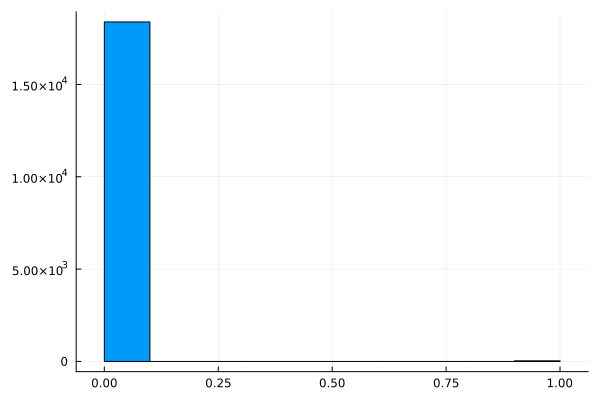

In [72]:
histogram(bulkscan_null_grid_results10_ml.h2_null_list, label = false)

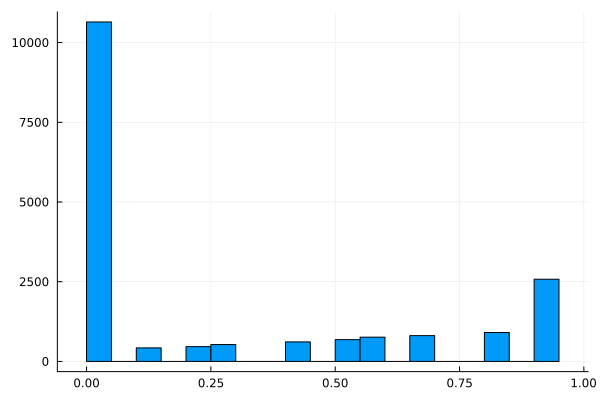

In [71]:
histogram(bulkscan_null_grid_results10_reml.h2_null_list, label = false)

In [73]:
12422*m/1000

228763.552

### Single trait scans

In [ ]:
omics_id = 832;

In [ ]:
test_y = reshape(omics_pheno_processed[:, omics_id], :, 1);

In [ ]:
@time scan_null_results_reml_perms = scan(test_y, omics_geno_processed, omics_kinship; 
                                    assumption = "null", reml = true,
                                    permutation_test = true, nperms = 1000);

In [ ]:
size(omics_geno_processed)

In [ ]:
p

In [ ]:
scan_null_results_reml_perms.L_perms

#### Null estimation for h2:

In [ ]:
@time scan_null_results_reml = scan(test_y, omics_geno_processed, omics_kinship; 
                                    assumption = "null", reml = true);

In [ ]:
scan_null_results_reml.h2_null

In [ ]:
@time bulkscan_null_results_reml = bulkscan_null(test_y, omics_geno_processed, omics_kinship; 
                                                 reml = true);

In [ ]:
bulkscan_null_results_reml.h2_null_list

#### Alt estimation for h2:

In [ ]:
@time scan_alt_results_reml = scan(test_y, omics_geno_processed, omics_kinship; 
                                   assumption = "alt", reml = true);

In [ ]:
@time bulkscan_alt_results_reml = bulkscan_alt_grid(test_y, omics_geno_processed, omics_kinship, grid_fine; 
                                                    reml = true);

In [ ]:
hcat(scan_alt_results_reml.h2_each_marker, bulkscan_alt_results_reml.h2_panel)

### Some helper functions:

#### LOD and p conversion helper functions

In [ ]:
function p2lod(pval::Float64, df::Int64)
    
    lrs = invlogcdf(Chisq(df), log(1-pval))
    lod = lrs/(2*log(10))
    
    return lod

end

function lod2p(lod::Float64, df::Int64)
    
    lrs = lod*2*log(10);
    pval = 1-cdf(Chisq(df), lrs)
    
    return pval
    
end

#### Profile helper functions

In [ ]:
## Helper functions for conducting genome-wide assoication analysis of a single trait

### Function to compute thresholds from permutation testing results:
### Inputs: 
###     - nperms_results - A matrix of LOD scores, each column contains the LOD scores 
###       fitted for each permuted copy;
###     - probs - A list contains the requested estimated (right-tail) probabilities 
###       the thresholds correspond to.
### Outputs:
###     - An object containing the quantiles of maximal LOD scores among all maximal 
###       LOD scores for all permutations and the corresponding probabilities . 

function get_thresholds(L::Array{Float64, 2}, thr_probs::Array{Float64, 1})

    # Get the LOD score peak for each trait
    peak_each_trait = vec(mapslices(x -> maximum(x), L; dims = 1));
    # Thresholds will be determined by the quantiles of the peaks
    thrs = map(x -> quantile(peak_each_trait, x), thr_probs);

    return (probs = thr_probs, thrs = thrs);

end

## Function to compute the loglikelihood value of the given data under LMM model:
## Inputs: data after rotation, a given h2 to evaluate loglik on
##         (optional) prior for regularization loglik near the upper boundary pt.
## Outputs: the logliks (null, alt mean model) under the given h2
function getLL(y0::Array{Float64, 2}, X0::Array{Float64, 2}, lambda0::Array{Float64, 1},
               num_of_covar::Int64, 
               markerID::Int64, h2::Float64; reml::Bool = false, prior::Array{Float64, 1} = [0.0, 0.0])
    
    n = size(y0, 1);
    w = makeweights(h2, lambda0);

    if num_of_covar == 1
        X0_covar = reshape(X0[:, 1], :, 1);
    else
        X0_covar = X0[:, 1:num_of_covar];
    end

    X_design = zeros(n, num_of_covar+1);
    X_design[:, 1:num_of_covar] = X0_covar;
    X_design[:, num_of_covar+1] = X0[:, markerID+num_of_covar];
    
    return (ll_null = wls(y0, X0_covar, w, prior; reml = reml).ell, ll_markerID = wls(y0, X_design, w, prior; reml = reml).ell)
end

function profileLL(y::Array{Float64, 2}, G::Array{Float64, 2}, covar::Array{Float64, 2}, 
                   K::Array{Float64, 2}, 
                   h2_grid::Array{Float64, 1}, markerID::Int64;
                   reml::Bool = false,
                   prior::Array{Float64, 1} = [0.0, 0.0])

    ## Initiate the vector to store the profile likelihood values evaluated under each given parameter value
    ell_null = zeros(length(h2_grid)); # loglikelihood under null
    ell_alt = zeros(length(h2_grid)); # loglikelihood under alternative


    num_of_covar = size(covar, 2);
    (y0, X0, lambda0) = transform_rotation(y, [covar G], K; addIntercept = false);

    ## Loop through the supplied h2 values, evaluate the profile loglik under each h2
    for k in 1:length(h2_grid)
        curr_h2 = h2_grid[k];
        output = getLL(y0, X0, lambda0, num_of_covar, markerID, curr_h2; 
                       reml = reml, prior = prior);
        ell_null[k] = output.ll_null;
        ell_alt[k] = output.ll_markerID;
    end

    ## Return values will be two (null, alternative models) lists of all loglikelihood values evaluated
    return (ll_list_null = ell_null, ll_list_alt = ell_alt);

end

## To be moved...
function plotLL(y::Array{Float64, 2}, G::Array{Float64, 2}, covar::Array{Float64, 2}, 
                K::Array{Float64, 2}, 
                h2_grid::Array{Float64, 1}, markerID::Int64;
                reml::Bool = false,
                x_lims::Array{Float64, 1}, y_lims::Array{Float64, 1},
                prior::Array{Float64, 1} = [0.0, 0.0])


    ell_null = zeros(length(h2_grid));
    ell_alt = zeros(length(h2_grid));


    num_of_covar = size(covar, 2);
    (y0, X0, lambda0) = transform_rotation(y, [covar G], K; addIntercept = false);

    for k in 1:length(h2_grid)
        curr_h2 = h2_grid[k];
        output = getLL(y0, X0, lambda0, num_of_covar, markerID, curr_h2; reml = reml, prior = prior);
        ell_null[k] = output.ll_null;
        ell_alt[k] = output.ll_markerID;
    end

    opt_ll_null = findmax(ell_null)[1];
    opt_h2_null = h2_grid[findmax(ell_null)[2]];
    opt_ll_alt = findmax(ell_alt)[1];
    opt_h2_alt = h2_grid[findmax(ell_alt)[2]];
    
    lb = min(findmin(ell_null)[1], findmin(ell_alt)[1]);
    ub = max(opt_ll_null, opt_ll_alt);

    p = plot(h2_grid, ell_null, xlabel = "h2", ylabel = "loglik", label = "Null", color = "blue", legend=:bottomleft)
    scatter!(p, [opt_h2_null], [opt_ll_null], label = "maxLL_null", color = "blue")
    plot!(p, h2_grid, ell_alt, xlabel = "h2", ylabel = "loglik", label = ("Alt_$markerID"), color = "red")
    scatter!(p, [opt_h2_alt], [opt_ll_alt], label = "maxLL_alt", color = "red");

    plot!(p, ones(2).*opt_h2_null, [lb-0.05, opt_ll_null], color = "blue", style = :dash, label = "")
    plot!(p, [x_lims[1]-0.05, opt_h2_null], ones(2).*opt_ll_null, color = "blue", style = :dash, label = "")
    annotate!(p, opt_h2_null, y_lims[1]-1.75, 
              text("$opt_h2_null", :blue, :below, 8))

    plot!(p, ones(2).*opt_h2_alt, [lb-0.05, opt_ll_alt], color = "red", style = :dash, label = "")
    plot!(p, [x_lims[1]-0.05, opt_h2_alt], ones(2).*opt_ll_alt, color = "red", style = :dash, label = "")
    annotate!(p, opt_h2_alt, lb-1.75, 
              text("$opt_h2_alt", :red, :below, 8))


    xlims!(p, (x_lims[1]-0.05, x_lims[2]+0.05))
    ylims!(p, (lb-1.0), ub+1.0)
    #= 
    ylims!(p, (minimum([y_lims[1], minimum(ell_null), minimum(ell_alt)])-0.05, 
               maximum([y_lims[2], maximum(ell_null), maximum(ell_alt)])+0.05))

    =#
    return p

end

#### Results analysis:

In [ ]:
function meanAbsDiff(x, y)
    
    return mean(abs.(x .- y))
    
end

In [ ]:
function removeInfValues!(x, y)
    
    toRemove = findall(isinf.(x));
    toRemove2 = findall(isnan.(x));
    
    for inf_val in toRemove
        
        x[inf_val[1], inf_val[2]] = 0.0;
        y[inf_val[1], inf_val[2]] = 0.0;
        
    end
    
    for nan_val in toRemove2
        
        x[nan_val[1], nan_val[2]] = 0.0;
        y[nan_val[1], nan_val[2]] = 0.0;
        
    end
    
end

## GEMMA:

### Run gemma:

In [ ]:
gemma = "/home/zyu20/Softwares/gemma-0.98.5-linux-static-AMD64"

In [ ]:
# rand_samples = sample(1:m, 1000);

In [ ]:
rand_samples = readdlm("output/samples.txt", '\t') |> x -> Int.(x);

In [ ]:
rand_samples[1:6]

In [ ]:
# writedlm("output/samples.txt", rand_samples, '\t');

In [ ]:
pheno_filename = "data/GEMMA_data/hs_omics_pheno.txt";
geno_filename = "data/GEMMA_data/hs_omics_geno.txt";
kinship_filename = "data/GEMMA_data/hs_omics_kinship.txt";
output_filename = "results_univariate_LMM";

In [ ]:
#=
t_gemma = @elapsed gemma_samples_results = run_gemma(omics_pheno_processed[:, rand_samples], omics_geno_processed, omics_kinship,
                                        ["A", "B"], omics_marker_names_processed,
                                        pheno_filename, geno_filename, kinship_filename, 
                                        output_filename, 
                                        gemma);
=#

In [ ]:
#=
runtime_results_file = open("output/runtimes_omics.txt", "w")
write(runtime_results_file, "BulkLMM Alg:null_grid20 runtime = $t_null_grid20 seconds \n");
write(runtime_results_file, "BulkLMM Alg:null_grid100 runtime = $t_null_grid100 seconds \n");
write(runtime_results_file, "Gemma runtime = $t_gemma seconds");
close(runtime_results_file)
=#

In [ ]:
# writedlm("output/gemma_L_omics.txt", gemma_samples_results, '\t');

In [ ]:
@time gemma_samples_results = readdlm("output/gemma_L_omics.txt", '\t');

### Compare BulkLMM.null results with GEMMA on 1000 sample traits:

In [ ]:
bulklmm_samples_results_ml = bulkscan_null_grid_results100_ml.L[:, rand_samples];

In [ ]:
bulklmm_samples_results_reml = bulkscan_null_grid_results100_reml.L[:, rand_samples];

In [ ]:
gemma_copy = copy(gemma_samples_results);

In [ ]:
findfirst(isnan.(gemma_samples_results))

In [ ]:
findfirst(isnan.(gemma_copy))

In [ ]:
removeInfValues!(gemma_samples_results, bulklmm_samples_results_ml)

In [ ]:
gemma_samples_results = copy(gemma_copy);

In [ ]:
removeInfValues!(gemma_samples_results, bulklmm_samples_results_reml)

In [ ]:
mean_diff_ml = meanAbsDiff(gemma_samples_results, bulklmm_samples_results_ml)

In [ ]:
mean_diff_reml = meanAbsDiff(gemma_samples_results, bulklmm_samples_results_reml)

In [ ]:
quant_diff_ml = quantile(vec(abs.(gemma_samples_results .- bulklmm_samples_results_ml)), [0.25, 0.5, 0.75, 0.99]);

In [ ]:
quant_diff_reml = quantile(vec(abs.(gemma_samples_results .- bulklmm_samples_results_reml)), [0.25, 0.5, 0.75, 0.99]);

In [ ]:
p*1000

In [ ]:
p

In [ ]:
plot(vec(gemma_samples_results)[1:1000], label = "GEMMA")
plot!(vec(bulklmm_samples_results_reml)[1:1000], label = "BulkLMM")

In [ ]:
cor(vec(gemma_samples_results), vec(bulklmm_samples_results_reml))

In [ ]:
ones(3, 10)*ones(10)

In [ ]:
summary_diff = DataFrame(vcat([mean_diff_ml mean_diff_reml], hcat(quant_diff_ml, quant_diff_reml)), ["ML", "REML"]);
summary_diff = hcat(["Mean", "0.25", "0.50", "0.75", "0.99"], summary_diff)